# Basic Dataset Exploration

In [1]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
BASE_DIR = Path('/home/giovenko/Projects/real_or_not')
INPUT_DIR = BASE_DIR/'data/input'
OUTPUT_DIR = BASE_DIR/'data/output'

In [3]:
train_df = pd.read_csv(INPUT_DIR/'train.csv')
test_df = pd.read_csv(INPUT_DIR/'test.csv')

In the first submissions it turned out that the CV score on the training set is quite different from the score on the leaderboard. It is not clear why this is the case. In what follows we try to identify the differences between these two sets.

1. Where does the test set come from?
2. Are there clear "structural" differences between the two sets?
3. Are there issues in the training set that are absent from the test set, or vice-versa?
4. If any of the above issues is found, how do we fix it?

The first thing to do is to look at the raw data, and this can only be done by painstakingly scrolling through the texts. The analyses below are what should come next. We present it first, just as an example.

## Where does the test set come from?

We compare the first 10 ids from the training set with the first 10 ids from the test set

In [4]:
pd.DataFrame({'train': train_df.id[:10], 'test': test_df.id[:10]})

,train,test
0,1,0
1,4,2
2,5,3
3,6,9
4,7,11
5,8,12
6,10,21
7,13,22
8,14,27
9,15,29


The IDs in the test set seem to have been randomly selected from the training set. A two-sample Kolmogorov-Smirnov test on the IDs is not significant.

In [5]:
from scipy.stats import kstest

kstest(train_df.id, test_df.id)

KstestResult(statistic=0.013360817760191237, pvalue=0.8031734343752832)

Note that the tweets in the training set are **not** in random order. They are grouped by **keyword**. There are similar numbers of tweets for each class in the training set, as shown by the plot below.

Most keywords appear between 30 and 40 times. There is a small number of keywords that appear 10 times or less.
It is highly probably that tweets in the test set appearing with the same keyword be quite similar to those in the training set.

<AxesSubplot:>

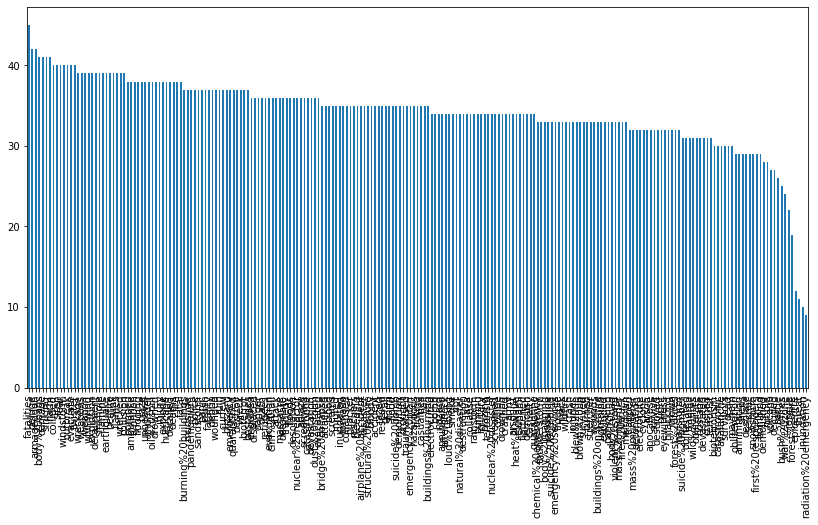

In [6]:
train_df.keyword.value_counts().plot(kind='bar', figsize=(14, 7))

In [7]:
print(len(train_df.keyword.unique()))
train_df.keyword.unique()

222


array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

All the keywords in the training set appear in the test set.

In [8]:
print(len(test_df.keyword.unique()))
test_df.keyword.isin(train_df.keyword.unique()).all()

222


True

The proportion of each keyword is similar in the two sets, with the exception of a subset of keywords that are anti-correlated.

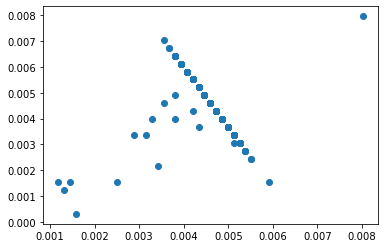

In [9]:
x = train_df.keyword.value_counts(normalize=True, dropna=False).sort_index()
y = test_df.keyword.value_counts(normalize=True, dropna=False).sort_index()

plt.plot(x, y, 'o')

In [10]:
del x, y

## Proportion of class labels per keyword

/home/giovenko/miniconda3/envs/ml/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='keyword'>

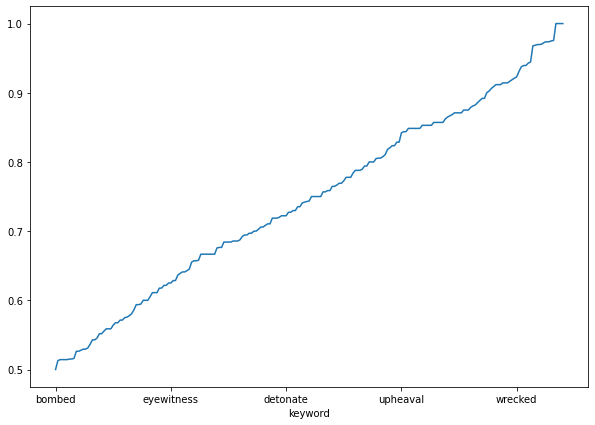

In [11]:
train_df.groupby('keyword').target.value_counts(normalize=True).groupby('keyword').nth(0).sort_values().plot(figsize=(10, 7))

## Distribution of the targets

First, we check what is the distribution of the output target labels. Obviously we don't know the distribution in the test set, but if we observe strong class imbalance, this may be a red flag.

In [12]:
train_df.target.value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

There is some modest imbalance, but nothing terrible.

Next we check whether the entries are properly shuffled. If we see, for example, that all targets equal to 1 are in the first half of the dataset, then this would be an issue.

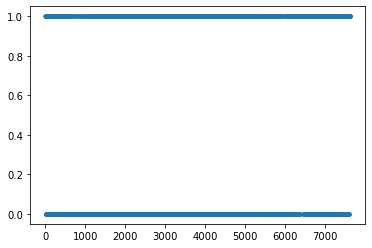

In [13]:
plt.plot(train_df.index, train_df.target, '.')

The plot is crude, but it doesn't seem to show problems.

Next we compute the length of the texts. If we see that shorter texts tend to be enriched in a class, the next step would be to inspect the length distribution in the test set.

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  text_length  
0       1           69  
1       1           38  
2       1          133  
3       1           65  
4       1           88  


<AxesSubplot:xlabel='text_length', ylabel='target'>

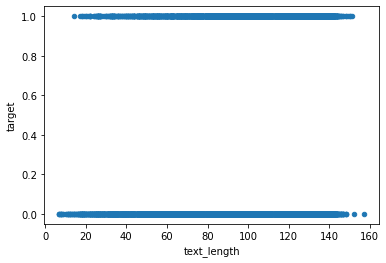

In [14]:
train_df['text_length'] = train_df['text'].str.len()
print(train_df.head())
train_df.plot('text_length', 'target', kind='scatter')

## Text inspection

From the visual inspection of the texts it turns out that there is a large number of identical texts that differ only by an http link. These texts, however, often have contradictory labels. For example, a number of texts contain the string

> U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse

In [15]:
s = 'U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse'
df = train_df[['keyword', 'text', 'target']]
df = df[df.text.str.contains(s)]

In [16]:
max_col_width = pd.options.display.max_colwidth
pd.options.display.max_colwidth = 140
df

,keyword,text,target
246,annihilation,U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... http://t.co/6LoJOoROuk via @Change,0
250,annihilation,U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... https://t.co/m8MvDSPJp7 via @Change,0
251,annihilation,U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... https://t.co/sW1sBua3mN via @Change,1
253,annihilation,U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... http://t.co/KPQk0C4G0M via @Change,1
259,annihilation,U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... https://t.co/MatIJwkzbh via @Change,0
266,annihilation,U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... https://t.co/x2Wn7O2a3w via @Change,0
270,annihilation,U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... https://t.co/0fekgyBY5F via @Change,0
271,annihilation,U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... http://t.co/SB5R7ShcCJ via @Change,1


The texts above are the same, and they all point to the same web page, but the target is 5 times 0 and 3 times 1.
We remove URLs and Twitter handles and take a majority vote over the entries, hoping that this will reduce the variability.

In [17]:
def process_txt(txt):
    txt = re.sub('@[^ ]+', '', txt)
    txt = re.sub('https?[^ ]+', '', txt)
    txt = txt.replace('#', '')
    txt = re.sub('\s+', ' ', txt)
    txt = re.sub('^ ', '', txt)
    return txt.lower()

We test the function above on texts containing handles and urls

In [18]:
train_texts = train_df.text.values
contains_url = [txt for txt in train_texts if txt.find('http') != -1]
contains_handle = [txt for txt in train_texts if txt.find('@') != -1]
dirty_txt = contains_url[:5] + contains_handle[:5]

clean_txt = [process_txt(txt) for txt in dirty_txt]
clean_txt

['wholesale markets ablaze ',
 'we always try to bring the heavy. metal rt ',
 'africanbaze: breaking news:nigeria flag set ablaze in aba. ',
 'on plus side look at the sky last night it was ablaze ',
 'inec office in abia set ablaze - ',
 'wholesale markets ablaze ',
 "mufc they've built so much hype around new acquisitions but i doubt they will set the epl ablaze this season.",
 'soooo pumped for ablaze ???? ',
 "noches el-bestia ' happy to see my teammates and training hard ?? goodnight gunners.?????? ",
 'set our hearts ablaze and every city was a gift and every skyline was like a kiss upon the lips ']

This function should be applied as part of a pipeline, together with the majority voting. We test the majority voting on the "Salt River Wild Horse" subset.

In [19]:
df

,keyword,text,target
246,annihilation,U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... http://t.co/6LoJOoROuk via @Change,0
250,annihilation,U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... https://t.co/m8MvDSPJp7 via @Change,0
251,annihilation,U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... https://t.co/sW1sBua3mN via @Change,1
253,annihilation,U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... http://t.co/KPQk0C4G0M via @Change,1
259,annihilation,U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... https://t.co/MatIJwkzbh via @Change,0
266,annihilation,U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... https://t.co/x2Wn7O2a3w via @Change,0
270,annihilation,U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... https://t.co/0fekgyBY5F via @Change,0
271,annihilation,U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... http://t.co/SB5R7ShcCJ via @Change,1


In [20]:
df['text'] = df['text'].apply(process_txt)
df

,keyword,text,target
246,annihilation,u.s national park services tonto national forest: stop the annihilation of the salt river wild horse... via,0
250,annihilation,u.s national park services tonto national forest: stop the annihilation of the salt river wild horse... via,0
251,annihilation,u.s national park services tonto national forest: stop the annihilation of the salt river wild horse... via,1
253,annihilation,u.s national park services tonto national forest: stop the annihilation of the salt river wild horse... via,1
259,annihilation,u.s national park services tonto national forest: stop the annihilation of the salt river wild horse... via,0
266,annihilation,u.s national park services tonto national forest: stop the annihilation of the salt river wild horse... via,0
270,annihilation,u.s national park services tonto national forest: stop the annihilation of the salt river wild horse... via,0
271,annihilation,u.s national park services tonto national forest: stop the annihilation of the salt river wild horse... via,1


In [21]:
tmp = df.groupby(['keyword', 'text', 'target']).size().sort_values(ascending=False).reset_index()

In [22]:
tmp.groupby(['keyword', 'text', 'target']).nth(0)

0
keyword      text                                                                                                         target   
annihilation u.s national park services tonto national forest: stop the annihilation of the salt river wild horse... via  0       5
                                                                                                                          1       3

We apply this transformation to the training and to the test sets. First, we replace missing keywords by the string 'missing' in the training set.

In [23]:
train_df['keyword'] = train_df.keyword.fillna('missing')
train_df['clean_text'] = train_df['text'].apply(process_txt)
clean_train_df = train_df.groupby(['keyword', 'clean_text', 'target']).size().sort_values(ascending=False).reset_index()
clean_train_df = clean_train_df.groupby(['clean_text'], sort=False).nth(0)
clean_train_df

,keyword,target,0
clean_text,,,
watch this airport get swallowed up by a sandstorm in under a minute,sandstorm,1,24
wreckage 'conclusively confirmed' as from mh370: malaysia pm: investigators and the families of those who were...,wreckage,1,20
families to sue over legionnaires: more than 40 families affected by the fatal outbreak of legionnaires' disea...,outbreak,1,19
christian attacked by muslims at the temple mount after waving israeli flag via pamela geller - ...,attacked,1,15
hot funtenna: hijacking computers to send data as sound waves [black hat 2015] prebreak best,hijacking,0,12
...,...,...,...
online infantryman experimental military training tutorials shower down upon assertative intelligence as regard...,military,0,1
pakistan supreme court oks military courts to try civilians: the supreme court ruling would empower the milita...,military,0,1
russian ushanka winter military fur hat (xl61-62) with soviet badge link:,military,0,1


We inspect the entries with empty keyword (replaced by `missing`).

In [24]:
clean_train_df[clean_train_df.keyword == 'missing']

,keyword,target,0
clean_text,,,
there's an emergency evacuation happening now in the building across the street,missing,1,1
these boxes are ready to explode! exploding kittens finally arrived! gameofkittens explodingkittensû_,missing,0,1
this is ridiculous....,missing,0,1
three people died from the heat wave so far,missing,1,1
was in nyc last week!,missing,0,1
what a goooooooaaaaaal!!!!!!,missing,0,1
what a wonderful day!,missing,0,1
what's up man?,missing,0,1
the end!,missing,0,1


We clean up the text in the test set as well.

In [25]:
test_df['clean_text'] = test_df['text'].apply(process_txt)

In [26]:
clean_train_df.to_csv(INPUT_DIR/'clean_train_df.csv')
test_df.to_csv(INPUT_DIR/'clean_test_df.csv')

In [27]:
print(test_df.keyword.value_counts(normalize=True, dropna=False))

NaN                      0.007968
deluged                  0.007049
rubble                   0.006742
demolished               0.006742
annihilation             0.006436
                           ...   
radiation%20emergency    0.001532
forest%20fire            0.001532
threat                   0.001532
inundation               0.001226
epicentre                0.000306
Name: keyword, Length: 222, dtype: float64


## Location

In [28]:
print(train_df.location.value_counts(normalize=True, dropna=False))

NaN                   0.332720
USA                   0.013661
New York              0.009326
United States         0.006568
London                0.005911
                        ...   
KLA,Uganda            0.000131
On a beach            0.000131
Austin/Los Angeles    0.000131
#otrakansascity       0.000131
The Internet          0.000131
Name: location, Length: 3342, dtype: float64


In [29]:
print(test_df.location.value_counts(normalize=True, dropna=False))

NaN                               0.338645
New York                          0.011646
USA                               0.011339
Worldwide                         0.004903
United States                     0.004597
                                    ...   
9.25.14?8.5.15?10.6.15 | gen?     0.000306
On The Island: Nassau, Bahamas    0.000306
#ALLblacklivesmatter              0.000306
Minneapolis, MN                   0.000306
SweizyLand                        0.000306
Name: location, Length: 1603, dtype: float64
